In [22]:
# -*- coding: utf-8 -*-
# https://blog.csdn.net/m0_37606112/article/details/79344967
'''
编码 : aikes
日期 : 20180221
功能 : 验证腾讯openai的api
环境 ：win10+python3.6+opencv3.4+VS2017
'''

import hashlib  
import time  
import random  
import string
import requests  
import base64  
import requests
import cv2
import numpy as np
from urllib.parse import urlencode
import json #用于post后得到的字符串到字典的转换
import matplotlib.pyplot as plt
from io import BytesIO

import numpy as np
import urllib.request
import cv2

In [23]:
# METHOD #1: OpenCV, NumPy, and urllib
def url_to_image(url):
	# download the image, convert it to a NumPy array, and then read
	# it into OpenCV format
	resp = urllib.request.urlopen(url)
	image = np.asarray(bytearray(resp.read()), dtype="uint8")
	image = cv2.imdecode(image, cv2.IMREAD_COLOR)
 
	# return the image
	return image



In [15]:
def get_sign_code(params, app_key):
    ''' 生成签名CODE
    
    1. 计算步骤
    用于计算签名的参数在不同接口之间会有差异，但算法过程固定如下4个步骤。
    将<key, value>请求参数对按key进行字典升序排序，得到有序的参数对列表N
    将列表N中的参数对按URL键值对的格式拼接成字符串，得到字符串T（如：key1=value1&key2=value2），URL键值拼接过程value部分需要URL编码，URL编码算法用大写字母，例如%E8，而不是小写%e8
    将应用密钥以app_key为键名，组成URL键值拼接到字符串T末尾，得到字符串S（如：key1=value1&key2=value2&app_key=密钥)
    对字符串S进行MD5运算，将得到的MD5值所有字符转换成大写，得到接口请求签名
    2. 注意事项
    不同接口要求的参数对不一样，计算签名使用的参数对也不一样
    参数名区分大小写，参数值为空不参与签名
    URL键值拼接过程value部分需要URL编码
    签名有效期5分钟，需要请求接口时刻实时计算签名信息
    :param params: 参数字典
    :param app_key: 
    :return: 
    '''
    if params is None or type(params) != dict or len(params) == 0: return
    try:
        params = sorted(params.items(), key=lambda x:x[0])
        _str = ''
        for item in params:
            key = item[0]
            value = item[1]
            if value == '': continue
            _str += urllib.parse.urlencode({key: value}) + '&'
        _str += 'app_key=' + app_key
        _str = hashlib.md5(_str.encode('utf-8')).hexdigest()
        return _str.upper()
    except Exception as e:
        logger.error('tencen get_sign_code error [{}]'.format(e))


In [20]:

app_id = '2107872408' 
app_key = 'DvMF4dRYHQccBoiI'

'''
        腾讯openai鉴权签名计算步骤：（摘抄自官网）
            用于计算签名的参数在不同接口之间会有差异，但算法过程固定如下4个步骤。
        1 将<key, value>请求参数对按key进行字典升序排序，得到有序的参数对列表N
        2 将列表N中的参数对按URL键值对的格式拼接成字符串，得到字符串T（如：key1=value1&key2=value2），URL键值拼接过程value部分需要URL编码，URL编码算法用大写字母，例如%E8，而不是小写%e8
        3 将应用密钥以app_key为键名，组成URL键值拼接到字符串T末尾，得到字符串S（如：key1=value1&key2=value2&app_key=密钥)
        4 对字符串S进行MD5运算，将得到的MD5值所有字符转换成大写，得到接口请求签名
'''
def get_params(img):                         #鉴权计算并返回请求参数
    #请求时间戳（秒级），用于防止请求重放（保证签名5分钟有效
    time_stamp=str(int(time.time())) 
    #请求随机字符串，用于保证签名不可预测,16代表16位
    nonce_str = ''.join(random.sample(string.ascii_letters + string.digits, 16))

    params = {'app_id':app_id,                #请求包，需要根据不同的任务修改，基本相同
              'image':img,                    #文字类的任务可能是‘text’，由主函数传递进来
              'time_stamp':time_stamp,        #时间戳，都一样
              'nonce_str':nonce_str,          #随机字符串，都一样
              #'sign':''                      #签名不参与鉴权计算，只是列出来示意
             }

    sort_dict= sorted(params.items(), key=lambda item:item[0], reverse = False)  #字典排序
    sort_dict.append(('app_key',app_key))   #尾部添加appkey
    rawtext= urlencode(sort_dict).encode()  #urlencod编码
    sha = hashlib.md5()    
    sha.update(rawtext)
    md5text= sha.hexdigest().upper()        #MD5加密计算
    
    
    #sign = get_sign_code(params, API_KEY)
    params['sign']=md5text                  #将签名赋值到sign
    return  params                          #返回请求包

def main(): 
    '''
    #用python系统读取方法
    f = open('c:/girl.jpg','rb')
    img = base64.b64encode(f.read())   #得到API可以识别的字符串
     '''
    #用opencv读入图片
    frame = url_to_image('http://www.tianjin-air.com/captcha/sphinx?timestamp=95')
    #frame=cv2.imread('C:/Users/jtian/Python/out.png')
    plt.imshow(frame)
    plt.show()
    nparry_encode = cv2.imencode('.png', frame)[1]
    data_encode = np.array(nparry_encode)
    img = base64.b64encode(data_encode)    #得到API可以识别的字符串
    #print('img--------->', img)
    params = get_params(img)    #获取鉴权签名并获取请求参数

    url = "https://api.ai.qq.com/fcgi-bin/ocr/ocr_handwritingocr"  # 人脸分析
    #检测给定图片（Image）中的所有人脸（Face）的位置和相应的面部属性。位置包括（x, y, w, h），面部属性包括性别（gender）, 年龄（age）, 表情（expression）, 魅力（beauty）, 眼镜（glass）和姿态（pitch，roll，yaw）   
    res = requests.post(url,params).json()
    print('res--------->', res)
    
#     for obj in res['data']['face_list']:
#         #print(obj)
#         x=obj['x']
#         y=obj['y']
#         w=obj['width']
#         h=obj['height']
#         cv2.rectangle(frame,(x,y),(x+w,y+h),(255,255,255),2)
#         delt=h//5
#         cv2.putText(frame,'beauty :'+str(obj['gender']), (x+w+10, y+10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2,cv2.LINE_8, 0)
#         cv2.putText(frame,'age    :'+str(obj['age']), (x+w+10, y+10+delt*1), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2,cv2.LINE_8, 0)
#         cv2.putText(frame,'smile  :'+str(obj['expression']), (x+w+10, y+10+delt*2), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2,cv2.LINE_8, 0)
#         cv2.putText(frame,'beauty :'+str(obj['beauty']), (x+w+10, y+10+delt*3), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2,cv2.LINE_8, 0)
#         cv2.putText(frame,'glass   :'+str(obj['glass']), (x+w+10, y+10+delt*4), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2,cv2.LINE_8, 0)

#     cv2.imshow('img',frame)
#     #cv2.imwrite('./000.jpg',frame)
#     cv2.waitKey(0)



In [2]:


def local(pil_img): 
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    img = base64.b64encode(buffered.getvalue())
    params = get_params(img)    #获取鉴权签名并获取请求参数

    url = "https://api.ai.qq.com/fcgi-bin/ocr/ocr_handwritingocr"  # 人脸分析
    #检测给定图片（Image）中的所有人脸（Face）的位置和相应的面部属性。位置包括（x, y, w, h），面部属性包括性别（gender）, 年龄（age）, 表情（expression）, 魅力（beauty）, 眼镜（glass）和姿态（pitch，roll，yaw）   
    res = requests.post(url,params, timeout=10).json()
    print('res--------->', res)
    

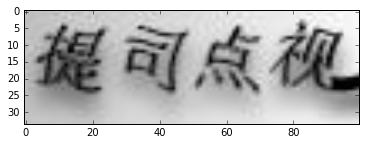

res---------> {'ret': 0, 'msg': 'ok', 'data': {'item_list': [{'item': '', 'itemstring': '提司点视', 'itemcoord': [{'x': 5, 'y': 5, 'width': 99, 'height': 31}], 'words': [{'character': '提', 'confidence': 0.997385}, {'character': '司', 'confidence': 0.988273}, {'character': '点', 'confidence': 0.999924}, {'character': '视', 'confidence': 0.998913}]}]}}


In [24]:
main()

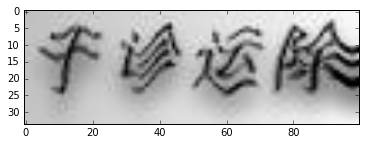

res---------> {'ret': 0, 'msg': 'ok', 'data': {'item_list': [{'item': '', 'itemstring': '于诊运除', 'itemcoord': [{'x': 6, 'y': 5, 'width': 96, 'height': 31}], 'words': [{'character': '于', 'confidence': 0.978063}, {'character': '诊', 'confidence': 0.951804}, {'character': '运', 'confidence': 0.987849}, {'character': '除', 'confidence': 0.965111}]}]}}


In [25]:
main()

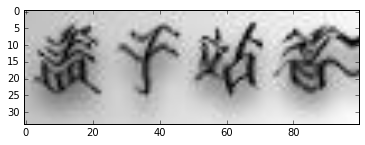

res---------> {'ret': 0, 'msg': 'ok', 'data': {'item_list': [{'item': '', 'itemstring': '潘于龄管', 'itemcoord': [{'x': 5, 'y': 5, 'width': 97, 'height': 26}], 'words': [{'character': '潘', 'confidence': 0.823166}, {'character': '于', 'confidence': 0.432562}, {'character': '龄', 'confidence': 0.795057}, {'character': '管', 'confidence': 0.324509}]}]}}


In [26]:
main()

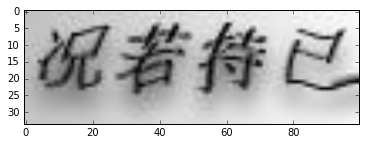

res---------> {'ret': 0, 'msg': 'ok', 'data': {'item_list': [{'item': '', 'itemstring': '沉若持已', 'itemcoord': [{'x': 3, 'y': 4, 'width': 93, 'height': 22}], 'words': [{'character': '沉', 'confidence': 0.955901}, {'character': '若', 'confidence': 0.783782}, {'character': '持', 'confidence': 0.98548}, {'character': '已', 'confidence': 0.982108}]}]}}


In [27]:
main()

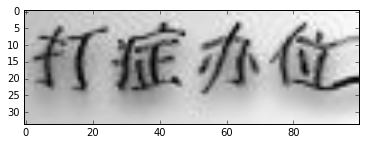

res---------> {'ret': 0, 'msg': 'ok', 'data': {'item_list': [{'item': '', 'itemstring': '打症办位', 'itemcoord': [{'x': 2, 'y': 4, 'width': 98, 'height': 22}], 'words': [{'character': '打', 'confidence': 0.992753}, {'character': '症', 'confidence': 0.99948}, {'character': '办', 'confidence': 0.999856}, {'character': '位', 'confidence': 0.979599}]}]}}


In [28]:
main()

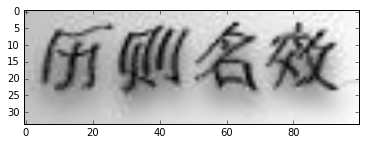

res---------> {'ret': 0, 'msg': 'ok', 'data': {'item_list': [{'item': '', 'itemstring': '历则名效', 'itemcoord': [{'x': 4, 'y': 4, 'width': 89, 'height': 21}], 'words': [{'character': '历', 'confidence': 0.585299}, {'character': '则', 'confidence': 0.999433}, {'character': '名', 'confidence': 0.999364}, {'character': '效', 'confidence': 0.974654}]}]}}


In [29]:
main()

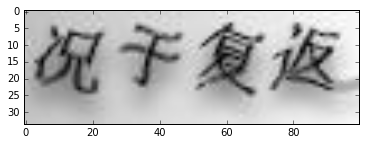

res---------> {'ret': 0, 'msg': 'ok', 'data': {'item_list': [{'item': '', 'itemstring': '沉子复返', 'itemcoord': [{'x': 2, 'y': 4, 'width': 92, 'height': 22}], 'words': [{'character': '沉', 'confidence': 0.643294}, {'character': '子', 'confidence': 0.984788}, {'character': '复', 'confidence': 0.998719}, {'character': '返', 'confidence': 0.865873}]}]}}


In [30]:
main()

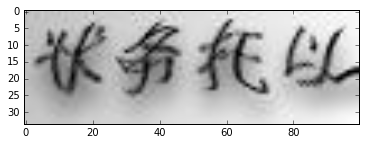

res---------> {'ret': 0, 'msg': 'ok', 'data': {'item_list': [{'item': '', 'itemstring': '长务托以', 'itemcoord': [{'x': 5, 'y': 5, 'width': 97, 'height': 25}], 'words': [{'character': '长', 'confidence': 0.453576}, {'character': '务', 'confidence': 0.817572}, {'character': '托', 'confidence': 0.789213}, {'character': '以', 'confidence': 0.979512}]}]}}


In [31]:
main()

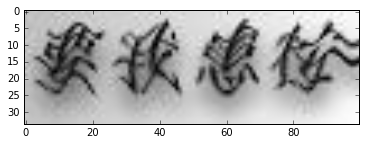

res---------> {'ret': 0, 'msg': 'ok', 'data': {'item_list': [{'item': '', 'itemstring': '葵状德趁', 'itemcoord': [{'x': 5, 'y': 5, 'width': 97, 'height': 26}], 'words': [{'character': '葵', 'confidence': 0.692148}, {'character': '状', 'confidence': 0.583524}, {'character': '德', 'confidence': 0.725611}, {'character': '趁', 'confidence': 0.540801}]}]}}


In [32]:
main()

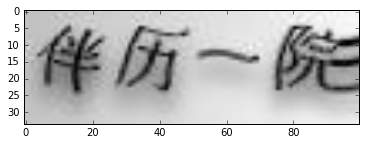

res---------> {'ret': 0, 'msg': 'ok', 'data': {'item_list': [{'item': '', 'itemstring': '伴历一院', 'itemcoord': [{'x': 4, 'y': 5, 'width': 99, 'height': 24}], 'words': [{'character': '伴', 'confidence': 0.999618}, {'character': '历', 'confidence': 0.99947}, {'character': '一', 'confidence': 0.8292}, {'character': '院', 'confidence': 0.93828}]}]}}


In [33]:
main()